# Parametric Model: Weibull Curve Estimation

In [8]:
# importing libraries
import math
import scipy
import lifelines
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from scipy.stats import weibull_min
from lifelines.datasets import load_dd

In [9]:
from lifelines import WeibullFitter

### Plotting the Weibull Distribution for different values of shape parameter k and scale paramter lambda = 1

c:\users\ankushukla\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


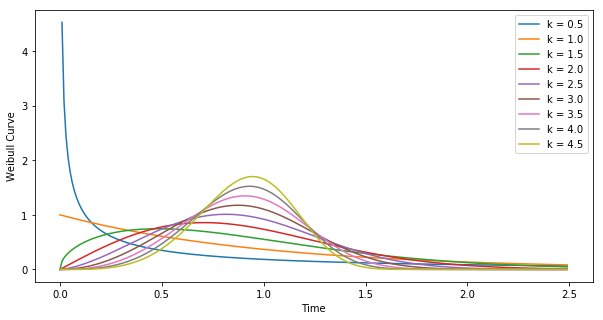

In [10]:
t = np.arange(0, 2.5, 0.01)
f, ax = plt.subplots(1, 1, figsize = (10, 5))
lamda = 1
ks = np.arange(0.5, 5, 0.5)
for k in ks:
    weibull = lambda x: np.power(x/lamda, k-1)*math.exp(-1*np.power(x/lamda, k))*(k/lamda)
    vect_weibull = np.vectorize(weibull)
    distribution = vect_weibull(t)
    w = sns.lineplot(x = t, y = distribution, ax = ax, label = 'k = {}'.format(k))
w.set_ylabel('Weibull Curve')
w.set_xlabel('Time')
plt.legend()
plt.show()

### Writing the functions for Maximum Likelihood Estimation of Weibull Curve

In [11]:
def fitweibull_uncensored(t):
    def optfun(theta):
        return -np.sum(np.log(theta[0]/theta[1]) + (theta[0] - 1)*np.log(t/theta[1]) - np.power(t/theta[1], theta[0]))
    
    logx = np.log(t)
    shape = 1.2 / np.std(logx)
    scale = np.exp(np.mean(logx) + (0.572 / shape))
   
    return fmin(optfun, [shape, scale], xtol = 0.01, ftol = 0.01, disp = 0)

def fitweibull_censored(t, u):
    def optfun(theta):
        return -np.sum(np.log(theta[0]/theta[1]) + (theta[0] - 1)*np.log(t/theta[1]) - np.power(t/theta[1], theta[0])) + np.sum(np.power(u/theta[1], theta[0]))
    
    logx = np.log(t)
    shape = 1.2 / np.std(logx)
    scale = np.exp(np.mean(logx) + (0.572 / shape))
   
    return fmin(optfun, [shape, scale], xtol = 0.01, ftol = 0.01, disp = 0)
    
def weibull_mle_estimation(df, censored = False):
    if(censored):
        theta = fitweibull_censored(df[df['censored'] == 0]['duration'], df[df['censored'] == 1]['duration'])
    else:
        theta = fitweibull_uncensored(df['duration'])
    
    return theta

def cdf(theta, t):
    beta, alpha = theta
    return np.exp(-np.power(t/alpha, beta))

### Using sample data present in Lifelines package

In [12]:
df = load_dd()
df.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


### Doing the estimation for only uncensored records

In [13]:
df.loc[:, 'censored'] = 1 - df['observed']

In [14]:
uncensored = df[df['censored'] == 0]

In [15]:
theta = weibull_mle_estimation(uncensored)
print('The estimated shape (k) and scale (lambda) parameters are {}, {}'.format(theta[0], theta[1]))

The estimated shape (k) and scale (lambda) parameters are 1.0428560945975036, 4.4065593991631475


### Verifying the results using Lifelines package

In [17]:
wbf = WeibullFitter()
T = uncensored["duration"]
E = uncensored["observed"]

wbf.fit(T, event_observed=E)
wbf.summary

,coef,se(coef),lower 0.95,upper 0.95,p,-log2(p)
lambda_,4.408714,0.117248,4.178912,4.638516,7.948367e-186,614.887967
rho_,1.042972,0.019398,1.004952,1.080993,2.674271e-02,5.224710


#### Result: We can see that our estimates lie well within the limits given by Lifelines package

### Estimation for complete data

In [18]:
theta = weibull_mle_estimation(df, censored = True)
print('The estimated shape (k) and scale (lambda) parameters are {}, {}'.format(theta[0], theta[1]))

The estimated shape (k) and scale (lambda) parameters are 0.9421044306322413, 6.108637802585237


### Verifying the results using Lifelines package

In [19]:
T = df["duration"]
E = df["observed"]

wbf.fit(T, event_observed=E)
wbf.summary

,coef,se(coef),lower 0.95,upper 0.95,p,-log2(p)
lambda_,6.110227,0.171868,5.773371,6.447082,2.840691e-194,642.947808
rho_,0.942647,0.017991,0.907386,0.977909,1.433366e-03,9.446377


#### Result: We can see that our estimates lie well within the limits given by Lifelines package

### Calculating the survival probabilities with our estimates and Lifelines package

In [25]:
vec_s = np.vectorize(lambda x: cdf(theta, x))
s = vec_s(wbf.survival_function_['Weibull_estimate'].index.values)

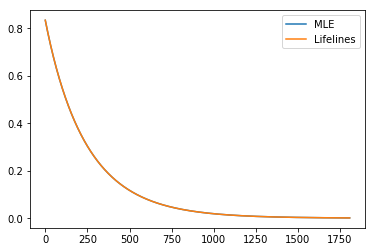

In [26]:
plt.plot(s, label = 'MLE')
plt.plot(wbf.survival_function_['Weibull_estimate'].values, label = 'Lifelines')
plt.legend()
plt.show()

#### Results: The curve match implying that our estimates are correct